## Import Data

In [11]:
# # re upload files everytime run

from google.colab import files

uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [24]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

import math

In [12]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

frames_X = [X_train, X_test]
frames_y = [y_train, y_test]

X = pd.concat(frames_X)
y = pd.concat(frames_y)

#X = X.iloc[:,13:].copy() # select only features

print(X.shape)
print(y.shape)

(191, 120)
(191, 1)
(48, 120)
(48, 1)
(239, 120)
(239, 1)


In [49]:
X_normal = X.loc[y['OverallPoF'] == 0,]
X_features_only = X.iloc[:,13:]
X_features_only['OverallPoF'] = y['OverallPoF']
X_normal_features_only = X_normal.iloc[:,13:]
print(X_normal_features_only.shape)

(201, 107)


In [52]:
X_normal_features_only_long = X_normal_features_only.melt(var_name='Frequency', value_name='WBA')
X_features_only_long = X_features_only.melt(id_vars='OverallPoF', var_name='Frequency', value_name='Absorbance')

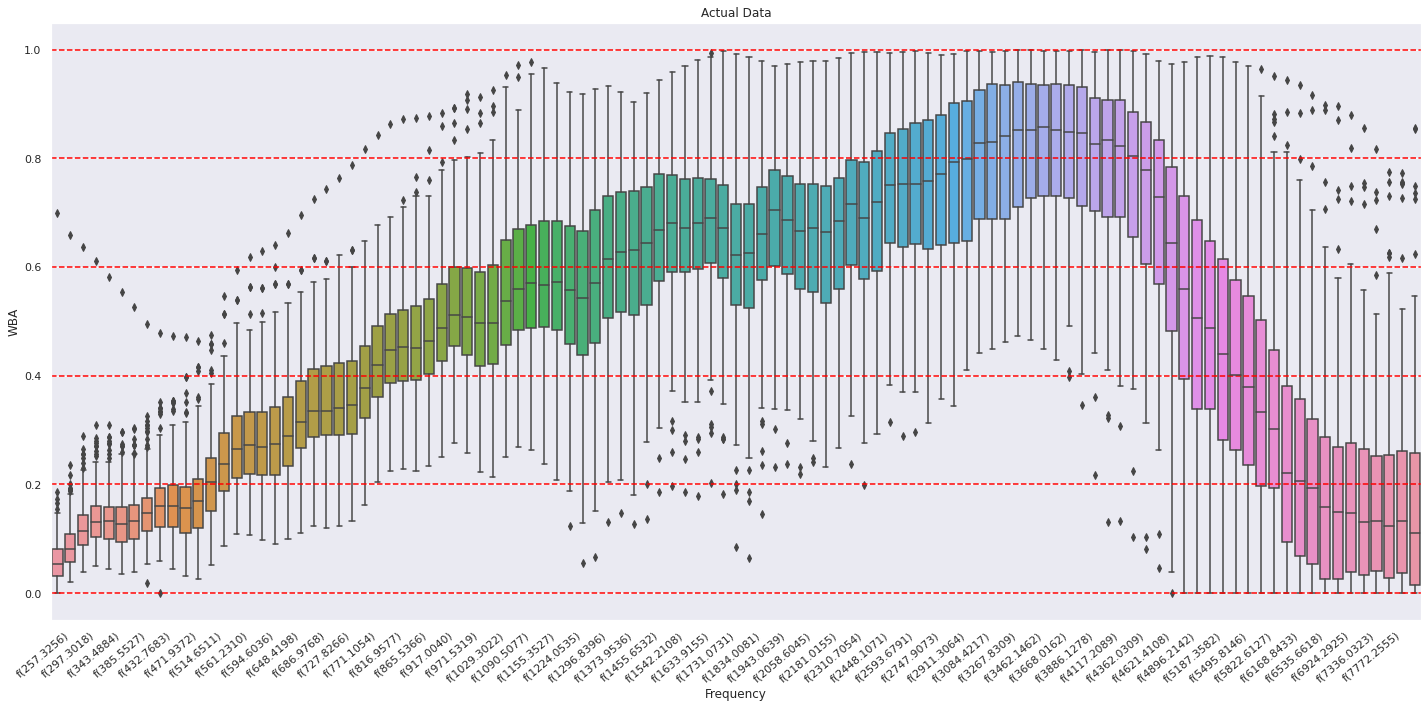

In [23]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="WBA", data=X_normal_features_only_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Actual Data')
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

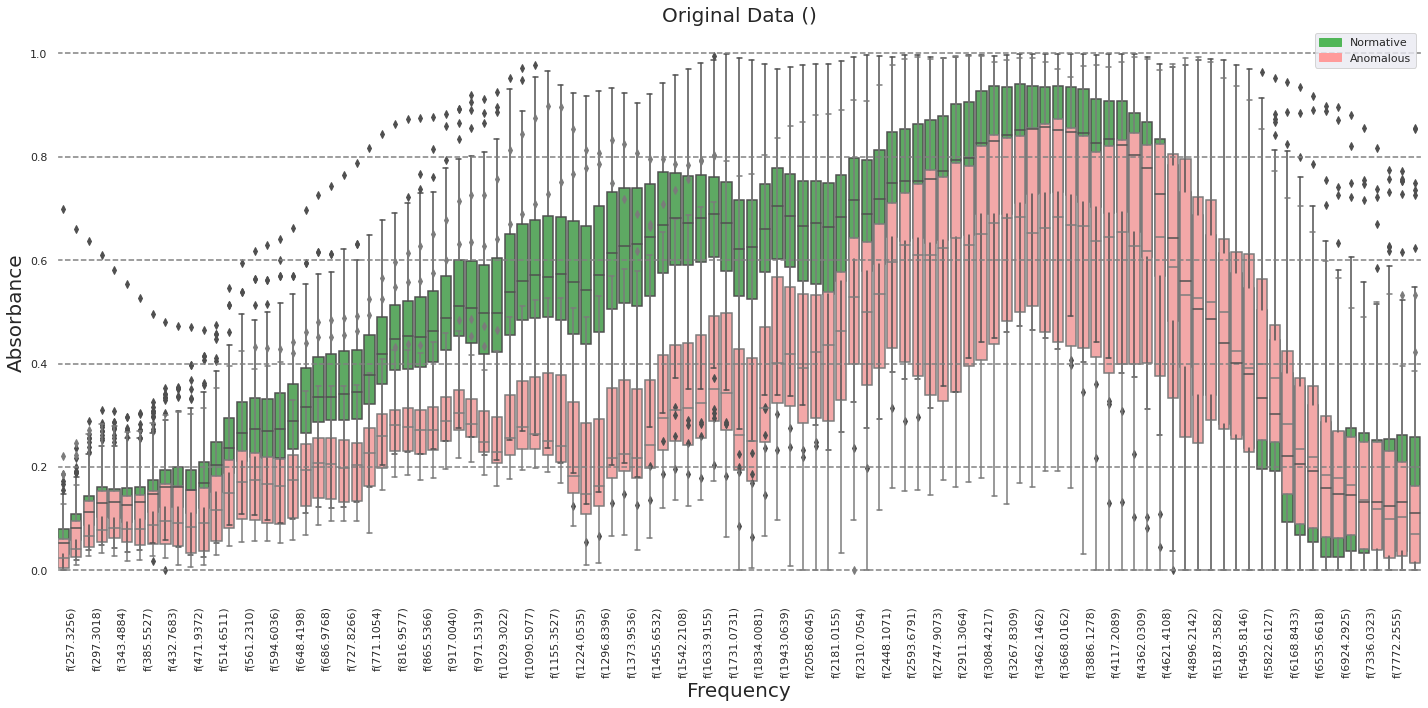

In [54]:
import matplotlib.patches as mpatches

sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="Absorbance", data=X_features_only_long[X_features_only_long["OverallPoF"] == 0], color='#51b658')
ax = sns.boxplot(x="Frequency", y="Absorbance", data=X_features_only_long[X_features_only_long["OverallPoF"] == 1], color='#ff9b9b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

ax.axes.set_title('Original Data ({})'.format(""), fontsize=20)
ax.set_xlabel("Frequency", fontsize=20)
ax.set_ylabel("Absorbance",fontsize=20)

ax.axhline(1.0, ls='--', color='grey')
ax.axhline(0.8, ls='--', color='grey')
ax.axhline(0.6, ls='--', color='grey')
ax.axhline(0.4, ls='--', color='grey')
ax.axhline(0.2, ls='--', color='grey')
ax.axhline(0.0, ls='--', color='grey')

ax.patch.set_facecolor('white')
plt.setp(ax.get_xticklabels()[::2], visible=False)
green_patch = mpatches.Patch(color='#51b658', label='Normative')
pink_patch = mpatches.Patch(color='#ff9b9b', label='Anomalous')
plt.legend(handles=[green_patch, pink_patch])

plt.tight_layout()
plt.show();

## GAN Model

In [110]:
torch.manual_seed(111)

In [111]:
train_set = torch.tensor(X_features_only.values, dtype=torch.float32)
train_set.shape

torch.Size([239, 108])

In [112]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [115]:
latent_shape_size = 15
num_features = 108

In [116]:
# LeakyReLU activation

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_shape_size, 30),
        nn.LeakyReLU(0.1),
        nn.Linear(30, 40),
        nn.LeakyReLU(0.1),
        nn.Linear(40, 60),
        nn.LeakyReLU(0.1),
        nn.Linear(60, num_features),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    output = self.model(x)
    return output

generator = Generator()

In [117]:
# SELU activation

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_shape_size, 30),
        nn.SELU(0.1),
        nn.Linear(30, 40),
        nn.SELU(0.1),
        nn.Linear(40, 60),
        nn.SELU(0.1),
        nn.Linear(60, num_features),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    output = self.model(x)
    return output

generator = Generator()

In [118]:
# LeakyReLU activation

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 60),
        nn.LeakyReLU(0.1),
        nn.Linear(60, 30),
        nn.LeakyReLU(0.1),
        nn.Linear(30, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    output = self.model(x)
    return output

discriminator = Discriminator()

In [119]:
# SELU activation

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 60),
        nn.SELU(0.1),
        nn.Linear(60, 30),
        nn.SELU(0.1),
        nn.Linear(30, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    output = self.model(x)
    return output

discriminator = Discriminator()

In [120]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [121]:
for epoch in range(num_epochs): # 1 min per 10 epochs
  for n, real_samples in enumerate(train_loader):
    if len(real_samples) != batch_size:
      continue
    
    # Data for training the discriminator
    real_samples_labels = torch.ones((batch_size, 1))
    latent_space_samples = torch.randn((batch_size, latent_shape_size))
    generated_samples = generator(latent_space_samples)
    generated_samples_labels = torch.zeros((batch_size, 1))
    all_samples = torch.cat((real_samples, generated_samples))
    all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

    # Training the discriminator
    # discriminator.zero_grad()
    output_discriminator = discriminator(all_samples)
    loss_discriminator = loss_function(output_discriminator, all_samples_labels)
    optimizer_discriminator.zero_grad()
    loss_discriminator.backward()
    optimizer_discriminator.step()

    # Data for training the generator
    latent_space_samples = torch.randn((batch_size, latent_shape_size))

    # Training the generator
    # generator.zero_grad()
    generated_samples = generator(latent_space_samples)
    output_discriminator_generated = discriminator(generated_samples)
    loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
    optimizer_generator.zero_grad()
    loss_generator.backward()
    optimizer_generator.step()
    
    # Show loss
    if epoch % 50 == 0:
      print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
      print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.679297149181366
Epoch: 0 Loss G.: 0.6955316662788391
Epoch: 0 Loss D.: 0.6564372777938843
Epoch: 0 Loss G.: 0.7279633283615112
Epoch: 0 Loss D.: 0.6299200057983398
Epoch: 0 Loss G.: 0.7605900764465332
Epoch: 50 Loss D.: 1.013589859008789
Epoch: 50 Loss G.: 1.3607184886932373
Epoch: 50 Loss D.: 0.9940130114555359
Epoch: 50 Loss G.: 1.4376111030578613
Epoch: 50 Loss D.: 0.9415611624717712
Epoch: 50 Loss G.: 1.1777995824813843
Epoch: 100 Loss D.: 0.9767633676528931
Epoch: 100 Loss G.: 0.8310795426368713
Epoch: 100 Loss D.: 0.9771559238433838
Epoch: 100 Loss G.: 0.8540067076683044
Epoch: 100 Loss D.: 0.9895443916320801
Epoch: 100 Loss G.: 0.6758027076721191
Epoch: 150 Loss D.: 0.3760683238506317
Epoch: 150 Loss G.: 1.6772202253341675
Epoch: 150 Loss D.: 0.3373963534832001
Epoch: 150 Loss G.: 1.494224190711975
Epoch: 150 Loss D.: 0.3507532477378845
Epoch: 150 Loss G.: 1.5146480798721313
Epoch: 200 Loss D.: 0.28950172662734985
Epoch: 200 Loss G.: 1.6464258432388306
Epoch:

In [181]:
latent_space_samples = torch.randn((10000, latent_shape_size))

In [182]:
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach().numpy()
generated_df = pd.DataFrame(generated_samples, columns=X_features_only.columns)
generated_df['OverallPoF'] = round(generated_df['OverallPoF']*20)
a = np.array(generated_df['OverallPoF'].values.tolist())
generated_df['OverallPoF'] = np.where(a > 1, 1, a).tolist()
generated_df['Id'] = np.arange(len(generated_df))
generated_df_long = generated_df.melt(id_vars=['Id','OverallPoF'], var_name='Frequency', value_name='Absorbance')

In [183]:
generated_df['OverallPoF'].value_counts()

0.0    8373
1.0    1627
Name: OverallPoF, dtype: int64

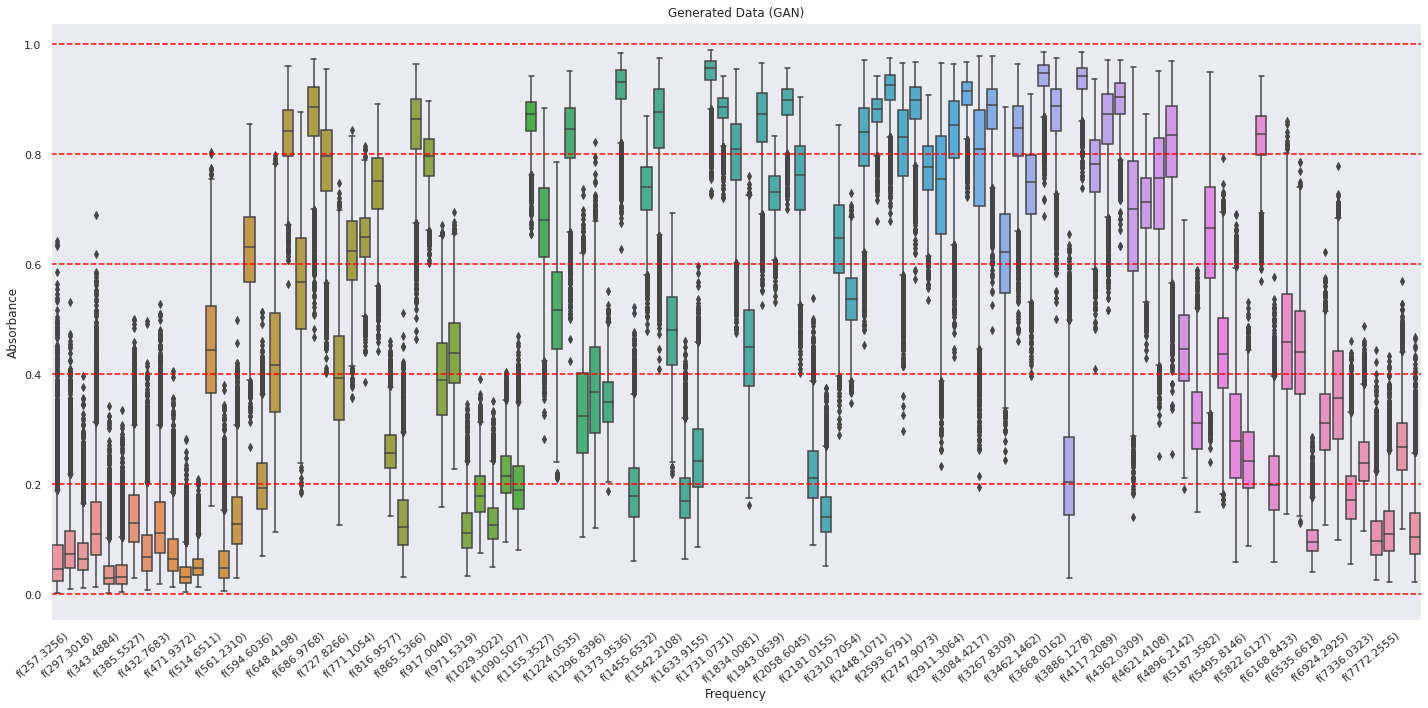

In [184]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="Absorbance", data=generated_df_long[generated_df_long["OverallPoF"] == 0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Generated Data ({})'.format('GAN'))
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

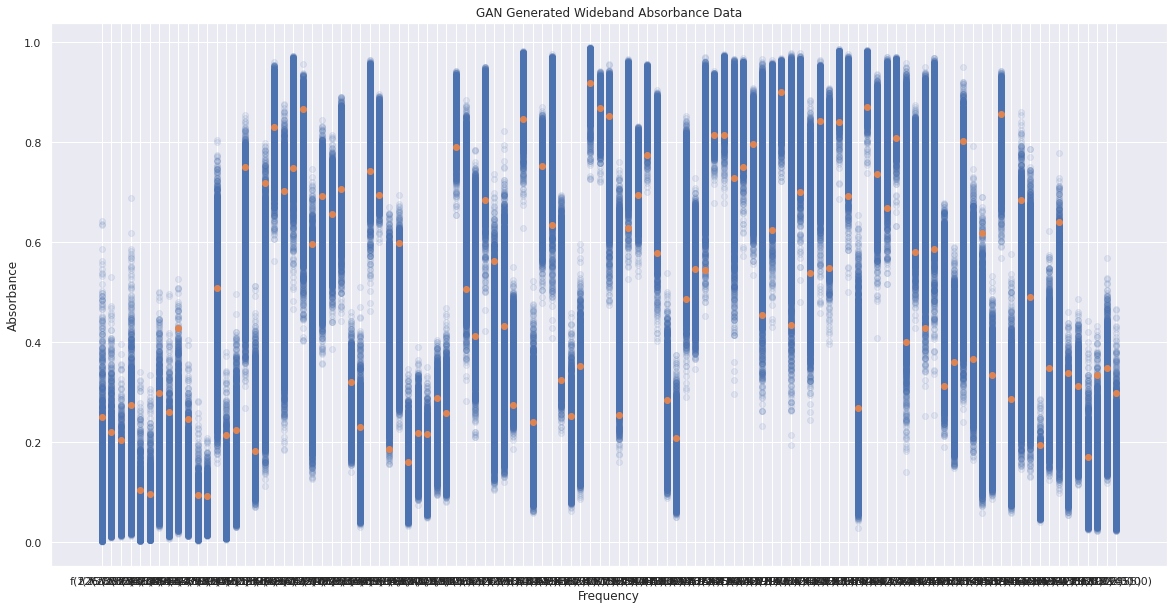

In [185]:
id = 2

fig, ax = plt.subplots()
ax.scatter(generated_df_long.loc[generated_df_long["OverallPoF"] == 0, "Frequency"], generated_df_long.loc[generated_df_long["OverallPoF"] == 0, "Absorbance"], alpha=0.1)
ax.scatter(generated_df_long.loc[generated_df_long['Id'] == id, "Frequency"], generated_df_long.loc[generated_df_long['Id'] == id, "Absorbance"])
ax.set_xlabel("Frequency")
ax.set_ylabel("Absorbance")
ax.set_title("GAN Generated Wideband Absorbance Data")
plt.show()

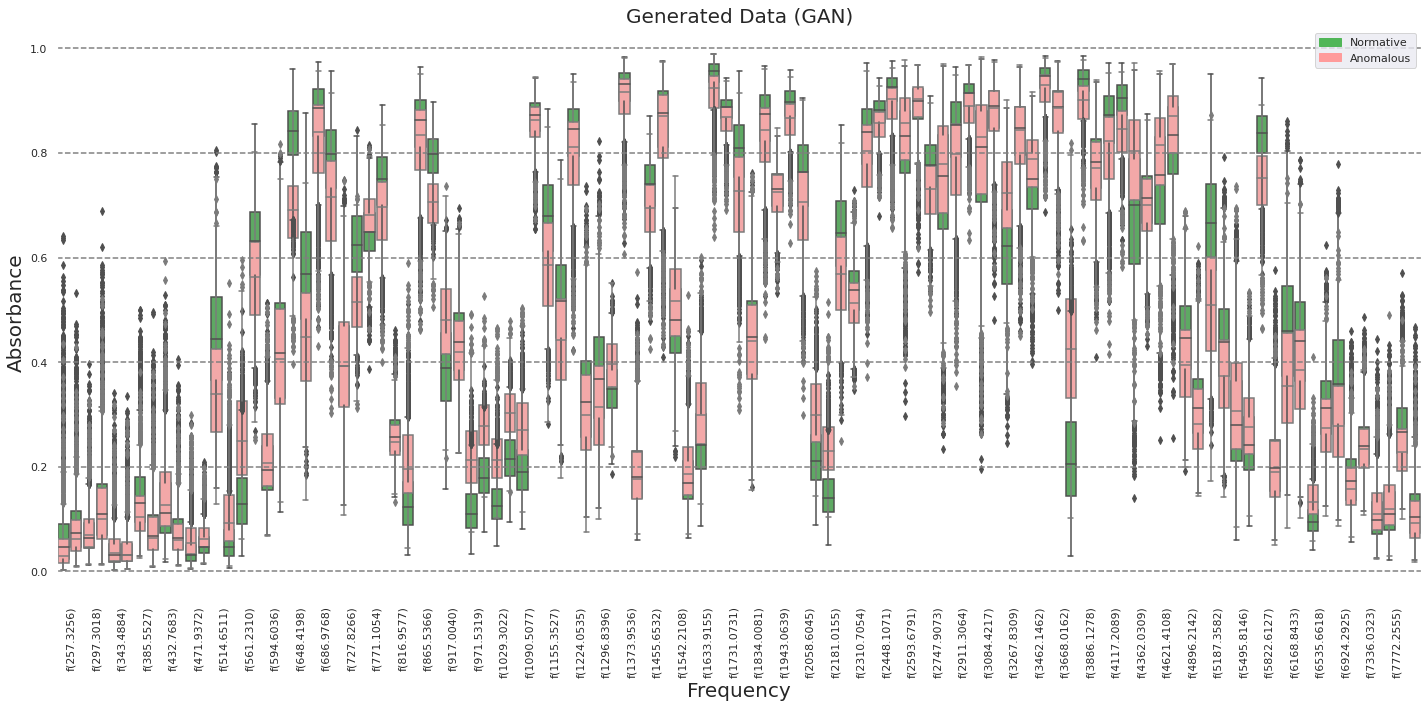

In [186]:
import matplotlib.patches as mpatches

sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="Absorbance", data=generated_df_long[generated_df_long["OverallPoF"] == 0], color='#51b658')
ax = sns.boxplot(x="Frequency", y="Absorbance", data=generated_df_long[generated_df_long["OverallPoF"] == 1], color='#ff9b9b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

ax.axes.set_title('Generated Data ({})'.format("GAN"), fontsize=20)
ax.set_xlabel("Frequency", fontsize=20)
ax.set_ylabel("Absorbance",fontsize=20)

ax.axhline(1.0, ls='--', color='grey')
ax.axhline(0.8, ls='--', color='grey')
ax.axhline(0.6, ls='--', color='grey')
ax.axhline(0.4, ls='--', color='grey')
ax.axhline(0.2, ls='--', color='grey')
ax.axhline(0.0, ls='--', color='grey')

ax.patch.set_facecolor('white')
plt.setp(ax.get_xticklabels()[::2], visible=False)
green_patch = mpatches.Patch(color='#51b658', label='Normative')
pink_patch = mpatches.Patch(color='#ff9b9b', label='Anomalous')
plt.legend(handles=[green_patch, pink_patch])

plt.tight_layout()
plt.show();